In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
#preprocessing
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS  #Word visualization
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

plt.style.use('ggplot')

### Dataset Loading

In [2]:
df= pd.read_csv('../dataset/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


### Exploratory Data Analysis

In [4]:
#Let's drop selected text & text id column
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True) #Resetting the index
original_df = df.copy(deep=True)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
print('Dimentions of dataset:', df.shape)

Dimentions of dataset: (27481, 2)


In [6]:
#Descriptive summary of dataset
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,All this flirting going on - The ATG smiles...,neutral
freq,1,11118


In [7]:
#Let's check Null values
df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [8]:
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

In [9]:
#Let's check Duplicates
df.duplicated().sum()

np.int64(0)

###### No duplicate values found

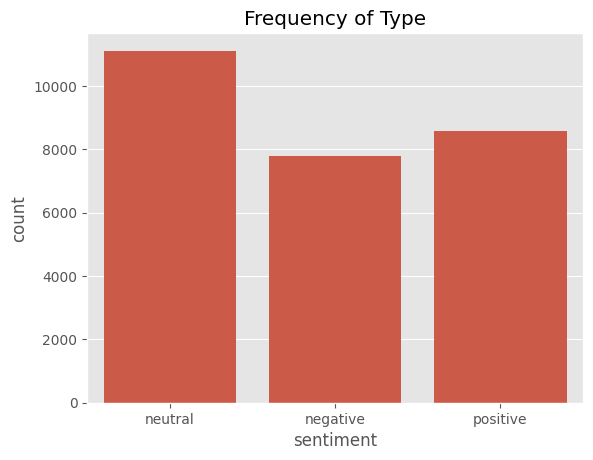

In [10]:
sns.countplot(data=df, x="sentiment")
plt.title("Frequency of Type")
plt.show()

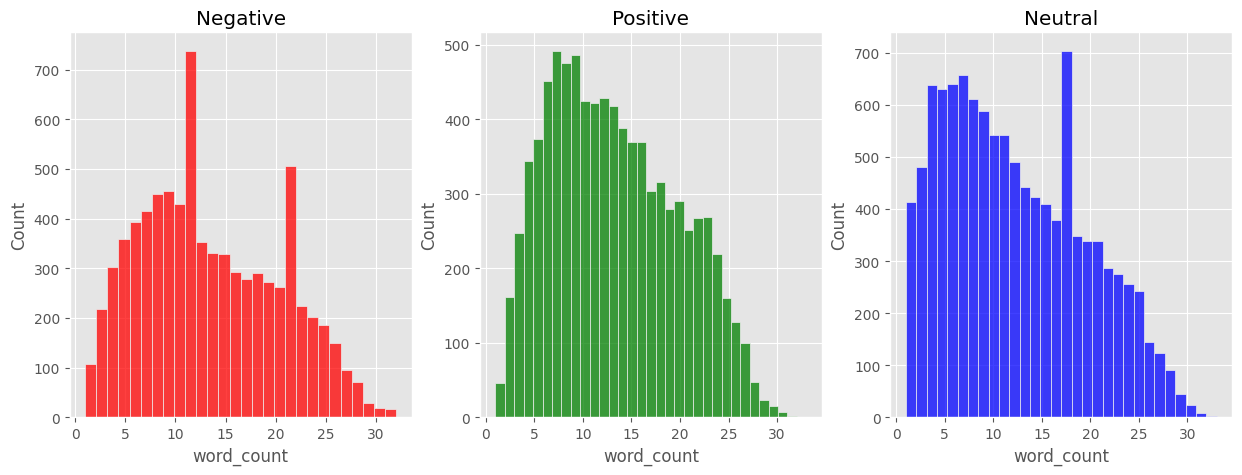

In [11]:
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(15, 5))

# Negative
plt.subplot(1, 3, 1)
sns.histplot(df[df['sentiment']=='negative']['word_count'], color='red')
plt.title("Negative")

# Positive
plt.subplot(1, 3, 2)
sns.histplot(df[df['sentiment']=='positive']['word_count'], color='green')
plt.title("Positive")

# Neutral
plt.subplot(1, 3, 3)
sns.histplot(df[df['sentiment']=='neutral']['word_count'], color='blue')
plt.title("Neutral")

plt.show()


###### The histogram shows that most tweets across all sentiments are short, with fewer long tweets, resulting in a right-skewed distribution for each sentiment.

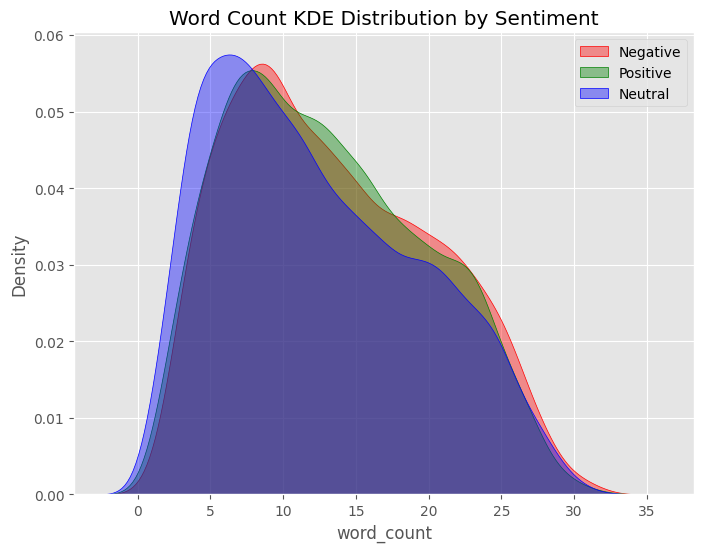

In [12]:
plt.figure(figsize=(8, 6))

sns.kdeplot(df[df['sentiment']=='negative']['word_count'], 
            label='Negative', color='red', fill=True, alpha=0.4)
sns.kdeplot(df[df['sentiment']=='positive']['word_count'], 
            label='Positive', color='green', fill=True, alpha=0.4)
sns.kdeplot(df[df['sentiment']=='neutral']['word_count'], 
            label='Neutral', color='blue', fill=True, alpha=0.4)

plt.title('Word Count KDE Distribution by Sentiment')
plt.legend()
plt.show()


###### Negative tweets tend to be the longest, positive tweets are slightly shorter, and neutral tweets are the shortest—creating right-skewed distributions across all sentiments.

##### Word Cloud

In [13]:
tweet = df["text"]
all_text = tweet.str.cat(sep=" ").lower()

tweet = df[df["sentiment"]=="positive"]["text"]
positive_text = tweet.str.cat(sep=" ").lower()

tweet = df[df["sentiment"]=="negative"]["text"]
negative_text = tweet.str.cat(sep=" ").lower()

tweet = df[df["sentiment"]=="neutral"]["text"]
neutral_text = tweet.str.cat(sep=" ").lower()

In [14]:
def generate_word_cloud(text, title="Tweets"):
    # Clean text
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"@\w+", "", text)          # remove mentions
    text = re.sub(r"\bRT\b", "", text)        # remove RT
    text = re.sub(r"[^a-zA-Z\s]", "", text)   # remove punctuation & numbers
    text = text.lower()

    # Create word cloud
    wordcloud = WordCloud(
        stopwords=STOPWORDS,
        width=3000,
        height=800,
        max_words=150,
        background_color="white",
        collocations=False,
        random_state=42
    ).generate(text)

    # Plot
    plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for: {title}", fontsize=28)
    plt.show()

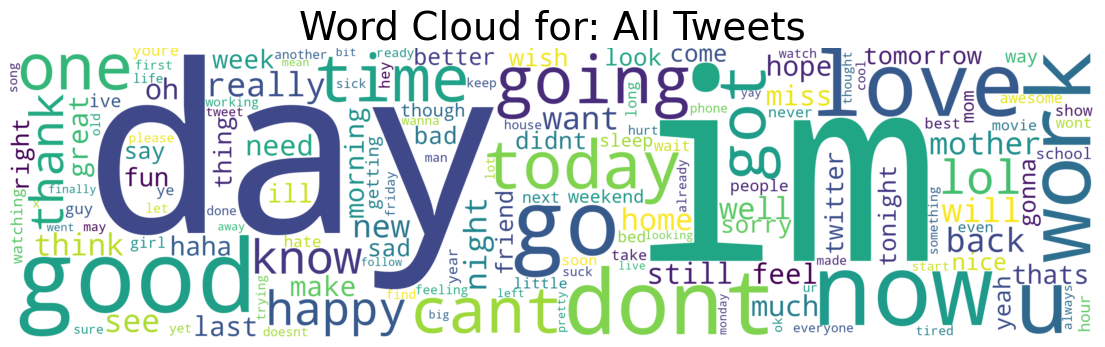

In [15]:
generate_word_cloud(all_text,"All Tweets")

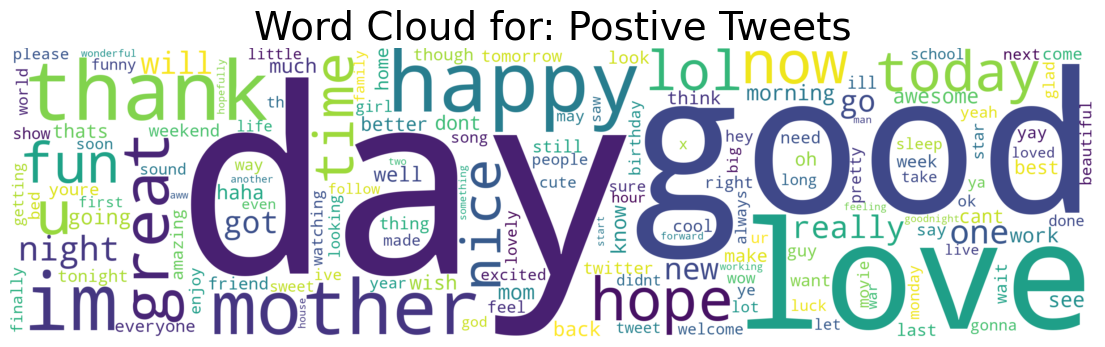

In [16]:
generate_word_cloud(positive_text,"Postive Tweets")

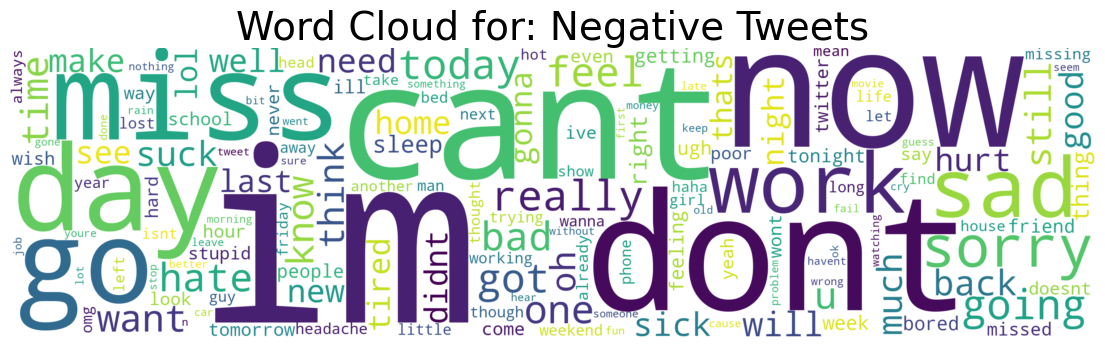

In [17]:
generate_word_cloud(negative_text,"Negative Tweets")

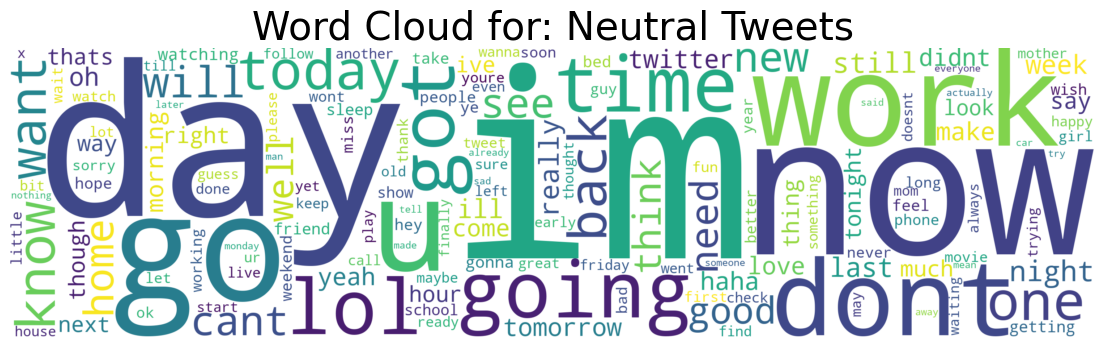

In [18]:
generate_word_cloud(neutral_text,"Neutral Tweets")

## Test Preprocessing

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [20]:
df.head()

,text,sentiment,word_count
0,"I`d have responded, if I were going",1,7
1,Sooo SAD I will miss you here in San Diego!!!,0,10
2,my boss is bullying me...,0,5
3,what interview! leave me alone,0,5
4,"Sons of ****, why couldn`t they put them on t...",0,14


In [21]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)    # Remove URLs
    text = re.sub(r'@\w+', '', text)              # Remove Mentions
    text = re.sub(r'#', '', text)                 # Remove Hashtag symbol
    text = re.sub(r'[^\w\s]', '', text)           # Remove Punctuation
    text = re.sub(r'\d+', '', text)               # Remove Numbers

    # Tokenize the cleaned text
    words = text.split()
    
    # Remove Stopwords AND Lemmatize
    lemmatized_words = [
        lemmatizer.lemmatize(w) for w in words if w not in stop_words
    ]
    
    return " ".join(lemmatized_words)

In [22]:
df['clean_text'] = df['text'].apply(clean_text)

# --- 2. Split Data ---
# Use the enhanced cleaned text for Naïve Bayes
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    df['clean_text'], df['sentiment'], test_size=0.2, random_state=42
)

In [23]:
df.head()

,text,sentiment,word_count,clean_text
0,"I`d have responded, if I were going",1,7,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,0,10,sooo sad miss san diego
2,my boss is bullying me...,0,5,bos bullying
3,what interview! leave me alone,0,5,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",0,14,son couldnt put release already bought


In [24]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_rf)
X_test_tfidf = vectorizer.transform(X_test_rf)

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    max_depth=None,        # Allows trees to grow fully
    random_state=42,
    class_weight='balanced', 
  )

In [26]:
rf_model.fit(X_train_tfidf, y_train_rf)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
y_pred_rf = rf_model.predict(X_test_tfidf)

In [28]:
def display_classification_report(y_true, y_pred):
  print(classification_report(y_true, y_pred))

In [29]:
print(classification_report(y_test_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.72      0.60      0.66      1572
           1       0.66      0.72      0.69      2236
           2       0.74      0.77      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.71      0.70      0.70      5496
weighted avg       0.70      0.70      0.70      5496



In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def display_ROC(y_test, y_prob, classes_, title=""):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes= classes_)

  plt.figure(figsize=(8, 6))

  for i, class_label in enumerate(classes_):
      fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"Multi-Class ROC Curve for {title}")
  plt.legend()
  plt.show()


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Confusion Matrix
def display_confusion_matrix(y_true, y_pred, title=""):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap='Blues')
  plt.title(f"Confusion Matrix for {title}")
  plt.show()



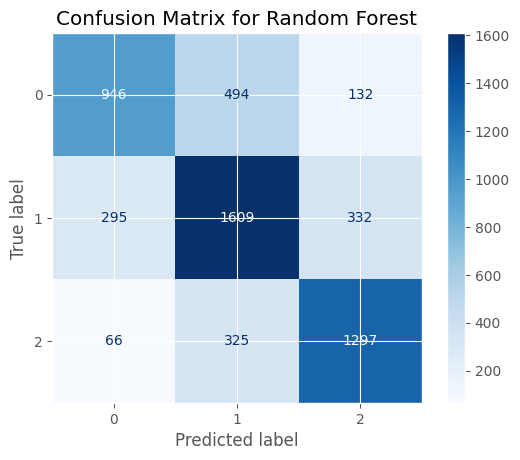

In [32]:
display_confusion_matrix(y_test_rf, y_pred_rf, title="Random Forest")